In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dense, Input, MaxPool2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, SeparableConv2D, Add, UpSampling2D
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
# from google.colab.patches import cv2_imshow

import numpy as np
import os
# import cv2
import random
import pandas as pd
import json
import tensorflow as tf
import math
import time

from tensorflow.keras.layers import Layer

class SSIMLayer(Layer):

  def __init__(self):
    super(SSIMLayer, self).__init__()

  def call(self, inputs):
    img1, img2 = inputs
    ssim = tf.image.ssim_multiscale(img1, img2, 1.0)
    return ssim

class AutoencoderBPR4(Model):
  def __init__(self):
    super(AutoencoderBPR4, self).__init__()
    self.encoder = Sequential([
      Input(shape=(224, 224, 1)),
      Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((2,2)),
      Conv2D(32, (4, 4), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((2,2)),
      Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((1,1)),
      Conv2D(32*2, (4, 4), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((2,2)),
      Conv2D(32*2, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((1,1)),
      Conv2D(32*4, (4, 4), activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((2,2)),
      Conv2D(32*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((1,1)),
      Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      MaxPooling2D((1,1)),
      Conv2D(256, (8, 8), strides=1, activation='linear', padding='valid'),
      ])

    self.decoder = Sequential([
      Conv2DTranspose(32, (8, 8), strides=1, activation=LeakyReLU(alpha=0.2), padding='valid'),
      Conv2D(32*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2D(32*4, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2DTranspose(32*2, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2D(32*2, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2DTranspose(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2DTranspose(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same'),
      Conv2DTranspose(1, (4, 4), strides=2, activation='sigmoid', padding='same'),
      ])
    
    self.ssim_layer = SSIMLayer()
  
    self.optimizer = Adam(learning_rate=1e-04)

  
  def call(self, x):
    anchor, img_test = x

    encoded_pos = self.encoder(anchor)
    decoded_pos = self.decoder(encoded_pos)
    ssim_pos = self.ssim_layer([anchor, decoded_pos])

    encoded_neg = self.encoder(img_test)
    decoded_neg = self.decoder(encoded_neg)
    ssim_neg = self.ssim_layer([anchor, decoded_neg])

    return ssim_pos, ssim_neg


    
#DEVI CALCOLARE SSIM TRA IMMAGINE CHE HO DATO COMWE NEG E LA POS
  
  @tf.function
  def train_step(self, data):
    img, neg = data

    with tf.GradientTape() as tape:
      ssim_pos, ssim_neg = self(data, training=True)
      
      difference = tf.clip_by_value(ssim_pos - ssim_neg, -1, 1)

      loss = tf.reduce_sum(tf.nn.softplus(-difference))

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    return {"loss": loss}
    

  @tf.function
  def test_step(self, data):
    # Unpack the data
    img, neg = data
    
    ssim_pos, ssim_neg = self(data, training=False)
    
    difference = tf.clip_by_value(ssim_pos - ssim_neg, -1, 1)
    test_loss = tf.reduce_sum(tf.nn.softplus(-difference))

    return {"test loss": test_loss}


  @tf.function
  def predict(self, data):
    ssim1, ssim2 = self(data, training=False)
    return ssim1, ssim2

autoencoderBPR4 = AutoencoderBPR4()
autoencoderBPR4.build([[None, 224, 224, 1], [None, 224, 224, 1]])
# autoencoderBPR4.load_weights('/content/autoencoder3108_1.hdf5')
autoencoderBPR4.load_weights('/content/autoencoderBPR4_19_09.hdf5')

2022-10-26 12:36:01.645382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 12:36:01.832405: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 12:36:02.610145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-10-26 12:36:02.610259: W tensorflow/stream_executor

In [1]:
!python --version

Python 3.9.13


In [2]:
def load_images_pca(path):
    img_list = []
    for im in sorted(os.listdir(path)):
        image = (load_img(os.path.join(path, 
                                    im), color_mode='grayscale'))
        image = img_to_array(image)
        image = np.divide(image, 255)
        image = image.astype('float32')
        img_list.append(image)

    img_list = np.array(img_list)
    return img_list


def load_image_and_pca(path, test_index, pca_dim):
    im_list_original = load_images_pca(path)
    im_test = im_list_original[test_index]

    d1, d2, d3, d4 = im_list_original.shape
    im_list_original_exp = im_list_original.reshape((d1, d2*d3*d4))
    im_list_original_exp = scale(im_list_original_exp)
    im_list_original_exp = PCA(n_components=pca_dim).fit_transform(im_list_original_exp)
    print(d1)
    im_test_exp = im_list_original_exp[test_index]

    im_list = np.delete(im_list_original, test_index, 0)

    d1, d2, d3, d4 = im_list.shape
    print(d1)
    im_list_exp = im_list.reshape((d1, d2*d3*d4))
    im_list_exp = scale(im_list_exp)

    im_list_exp = PCA(n_components=pca_dim).fit_transform(im_list_exp)

    return im_list, im_test, im_list_exp, im_test_exp


def retrive_best_indices(kmedoids, im_test_reshaped, labels):
    t1 = time.time()
    label = kmedoids.predict(np.expand_dims(im_test_reshaped, 0))
    indexes = np.where(labels == label)[0]
    t2 = time.time()
    print(f"cluster_predicting_time {t2-t1}")

    return indexes


def run_kmedoids_and_retrive_indexes(im_list_exp, k, im_test_exp):
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(im_list_exp)
    labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_
    indexes = retrive_best_indices(kmedoids, im_test_exp, labels)
    return kmedoids, labels, cluster_centers, indexes


def run_inference_clusters(autoencoderBPR4, im_test, im_list_indexes):
    t1 = time.time()
    _, ssim = autoencoderBPR4.predict([np.expand_dims(im_test, 0), im_list_indexes])

    max_ssim, index = 0, 0
    for i, ssimi in enumerate(ssim):
        if ssimi > max_ssim:
            max_ssim = ssimi
            index = i
    t2 = time.time()
    print(f"inference_time {t2-t1}")
    return max_ssim, index

def kmedoids_predict(cluster_centers, test_sample_exp):
    dist_list = []
    for center in cluster_centers:
        dist_list.append(np.linalg.norm(test_sample_exp-center))
    dist_list = np.array(dist_list)
    ordered_dist = sorted(dist_list)

    ind = [i for i, x in enumerate(dist_list) if x in ordered_dist[:3]]

    return dist_list, ind
    

# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/content/new_dataset_9000_11_08_grayscale/new_colored/", 6520, 2)
# kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
# max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

# print(f"max ssim is {max_ssim} at index {index}")
# plt.imshow((im_test*255).astype('uint8'))
# plt.show()
# plt.imshow((im_list[indexes][index]*255).astype('uint8'))
# plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.0004968643188476562


2022-10-26 08:55:56.962964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-10-26 08:55:57.818954: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-26 08:55:57.819009: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


inference_time 9.430594444274902
max ssim is 0.6255356073379517 at index 221


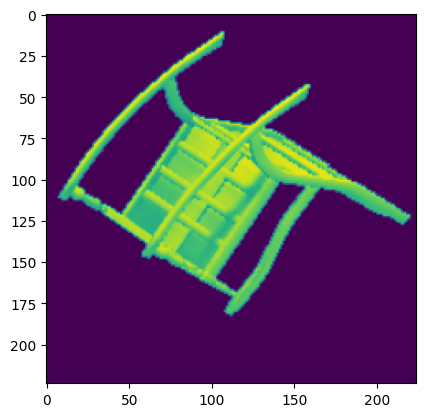

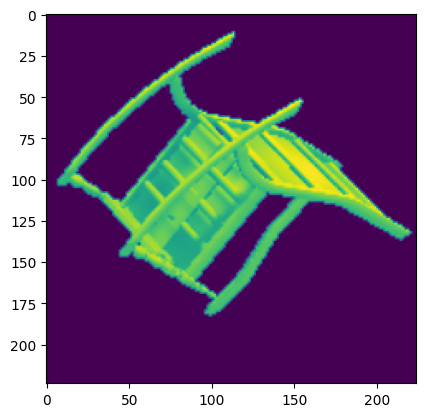

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 15, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.0004432201385498047


2022-10-26 08:59:46.255870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


inference_time 9.308975219726562
max ssim is 0.554497480392456 at index 23


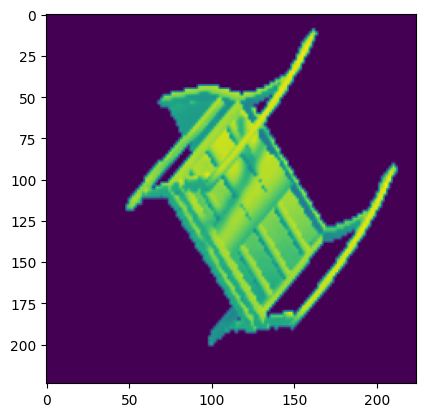

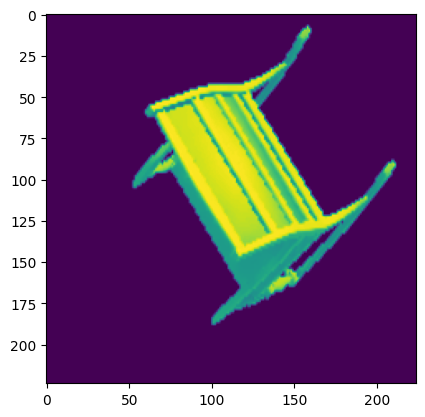

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 1999, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.00043773651123046875


2022-10-26 09:04:24.367428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-10-26 09:04:25.248501: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-26 09:04:25.248563: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


inference_time 9.639512538909912
max ssim is 0.624541699886322 at index 281


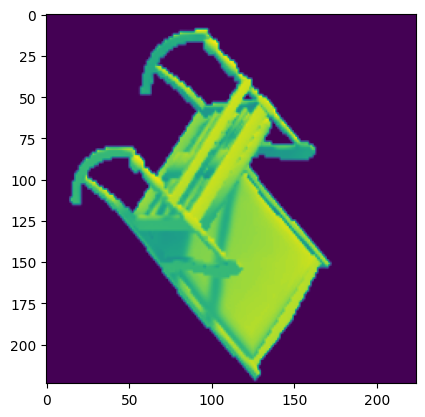

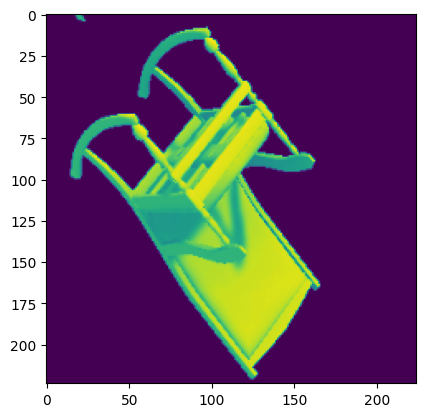

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 10, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.0005509853363037109


2022-10-26 09:07:42.182362: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-10-26 09:07:42.738709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


inference_time 13.459282159805298
max ssim is 0.5521612167358398 at index 115


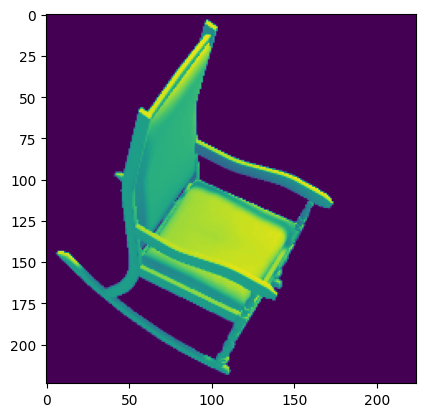

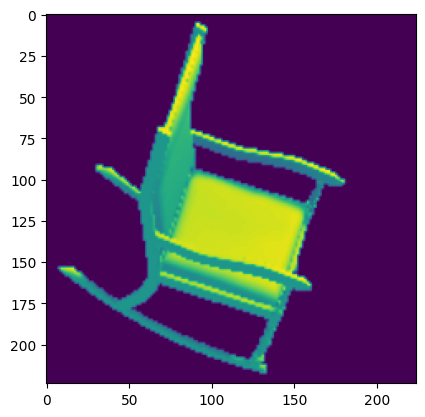

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 25, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


In [ ]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 27960, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.0005161762237548828


2022-10-26 09:12:36.923959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


inference_time 9.211184740066528
max ssim is 0.5880816578865051 at index 358


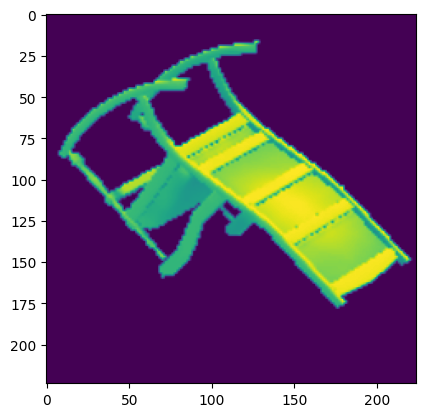

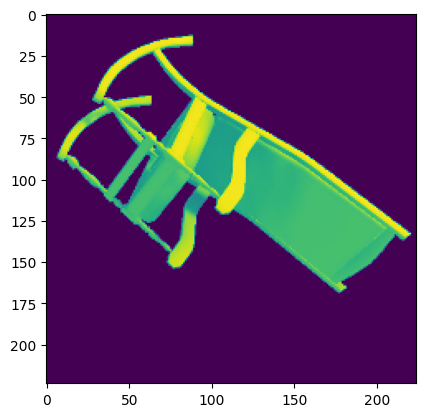

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 11111, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


29208
29207


/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


cluster_predicting_time 0.00044345855712890625


2022-10-26 09:15:56.299972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-10-26 09:15:57.137729: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-26 09:15:57.137784: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


inference_time 9.602283954620361
max ssim is 0.3787088096141815 at index 311


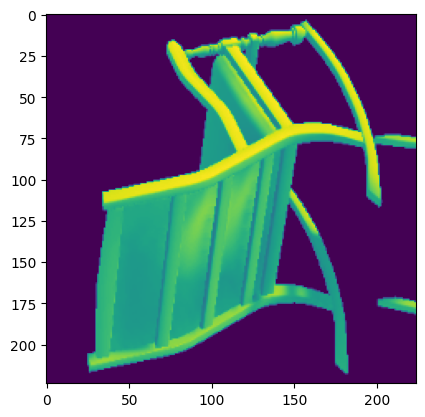

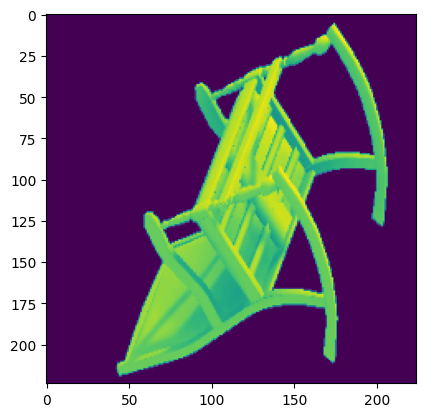

In [3]:
'''
ATTEMPT WITH NOBG IMGS ALREADY IN GRAYSCALE
'''
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 2003, 2)
kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

print(f"max ssim is {max_ssim} at index {index}")
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexes][index]*255).astype('uint8'))
plt.show()


In [ ]:
# import PIL
im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 15, 2)


In [ ]:
kmedoids = KMedoids(n_clusters=64, random_state=0).fit(im_list_exp)
labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_
mis, ind = kmedoids_predict(cluster_centers, im_test_exp)
print(mis)
print(ind)

In [ ]:
indexeeeeeees = []

for _ in ind:
    indexeeeeeees.append(retrive_best_indices(kmedoids, im_test_exp, labels))

In [15]:
print(len(np.array(indexeeeeeees)[0]))

485


In [ ]:
print(np.array(indexeeeeeees).shape)
im_list_indexes = im_list_exp[list(np.array(indexeeeeeees).flatten())]

max, ind = 0, 0
max_ssim_list, index_list = [],[]
for i, indeee in enumerate(indexeeeeeees):
    ii = im_list_indexes[indee]
    max_ssim, index =  run_inference_clusters(autoencoderBPR4, im_test, indeee)
    max_ssim_list.append(max_ssim)
    index_list.append(index)

    if max_ssim > max:
        max_ssim = max
        ind = i

print(max_ssim)
print(ind)


In [ ]:
print(np.array(indexeeeeeees).flatten())

im_list_indexes = im_list[list(np.array(indexeeeeeees).flatten())]

max_ssim, index =  run_inference_clusters(autoencoderBPR4, im_test, im_list_indexes)


In [ ]:
im_list_indexes = im_list_exp[list(np.array(indexeeeeeees).flatten())]
print(len(im_list))

25/10/2022

In [2]:
def load_images_pca(path):
    img_list = []
    for im in sorted(os.listdir(path)):
        image = (load_img(os.path.join(path, 
                                    im), color_mode='grayscale'))
        image = img_to_array(image)
        image = np.divide(image, 255)
        image = image.astype('float32')
        img_list.append(image)

    img_list = np.array(img_list)
    return img_list


def load_image_and_pca(path, test_index, pca_dim):
    im_list_original = load_images_pca(path)
    im_test = im_list_original[test_index]

    d1, d2, d3, d4 = im_list_original.shape
    im_list_original_exp = im_list_original.reshape((d1, d2*d3*d4))
    im_list_original_exp = scale(im_list_original_exp)
    im_list_original_exp = PCA(n_components=pca_dim).fit_transform(im_list_original_exp)
    print(d1)
    im_test_exp = im_list_original_exp[test_index]

    im_list = np.delete(im_list_original, test_index, 0)

    d1, d2, d3, d4 = im_list.shape
    print(d1)
    im_list_exp = im_list.reshape((d1, d2*d3*d4))
    im_list_exp = scale(im_list_exp)

    im_list_exp = PCA(n_components=pca_dim).fit_transform(im_list_exp)

    return im_list, im_test, im_list_exp, im_test_exp


def retrive_best_indices(kmedoids, im_test_reshaped, labels):
    t1 = time.time()
    label = kmedoids.predict(np.expand_dims(im_test_reshaped, 0))
    indexes = np.where(labels == label)[0]
    t2 = time.time()
    print(f"cluster_predicting_time {t2-t1}")

    return indexes


def run_kmedoids_and_retrive_indexes(im_list_exp, k, im_test_exp):
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(im_list_exp)
    labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_
    indexes = retrive_best_indices(kmedoids, im_test_exp, labels)
    return kmedoids, labels, cluster_centers, indexes


def run_inference_clusters(autoencoderBPR4, im_test, im_list_indexes):
    t1 = time.time()
    _, ssim = autoencoderBPR4.predict([np.expand_dims(im_test, 0), im_list_indexes])

    max_ssim, index = 0, 0
    for i, ssimi in enumerate(ssim):
        if ssimi > max_ssim:
            max_ssim = ssimi
            index = i
    t2 = time.time()
    print(f"inference_time {t2-t1}")
    return max_ssim, index

def kmedoids_predict(cluster_centers, test_sample_exp):
    dist_list = []
    for center in cluster_centers:
        dist_list.append(np.linalg.norm(test_sample_exp-center))
    dist_list = np.array(dist_list)
    ordered_dist = sorted(dist_list)

    ind = [i for i, x in enumerate(dist_list) if x in ordered_dist[:3]]

    return dist_list, ind
    

def dataLoaderImagesAutoencoderBPR(img_list_loaded, batch_size):
    L = len(img_list_loaded)
    k = int(np.ceil(L / batch_size))
    print(L)

    for i in range(0, k):
        print(i)
        start = int(math.floor(i * L / k))
        stop = int(math.floor((i + 1) * L / k))
        print(f"start is {start} while stop is {stop}")

        if stop > L:
            print('bau')
            x_img = img_list_loaded[start:L]
        
        else:
            x_img = img_list_loaded[start:stop]

        yield x_img

# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_colored/new_transparent/", 12321)
# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/content/new_dataset_9000_11_08_grayscale/new_colored/", 6520, 2)
# kmedoids, labels, cluster_centers, indexes = run_kmedoids_and_retrive_indexes(im_list_exp, 64, im_test_exp)
# max_ssim, index = run_inference_clusters(autoencoderBPR4, im_test, im_list[indexes])

# print(f"max ssim is {max_ssim} at index {index}")
# plt.imshow((im_test*255).astype('uint8'))
# plt.show()
# plt.imshow((im_list[indexes][index]*255).astype('uint8'))
# plt.show()

im_list = load_images_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/")

# im_list, im_test, im_list_exp, im_test_exp = load_image_and_pca("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 15, 2)
# kmedoids = KMedoids(n_clusters=64, random_state=0).fit(im_list_exp)
# labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_
# mis, ind = kmedoids_predict(cluster_centers, im_test_exp)
# print(mis)
# print(ind)

/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[224.94328  71.37783].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
pred = kmedoids.predict(np.expand_dims(im_test_pca, 0))
print(pred)

[59]


In [4]:
def retrive_best_indices_2(ind, labels):
    index_list = []
    for i in range(0, len(ind)):
        index_list.append(np.where(labels == ind[i])[0])
        # print(np.where(labels == i)[0].shape)
        print(i)
    return np.concatenate(index_list).ravel()


indexeeeeeees = []
indexeeeeeees = retrive_best_indices_2(ind, labels)


0
1
2


In [5]:
max_ssim, max_index = 0, 0

for i, d in enumerate(dataLoaderImagesAutoencoderBPR(im_list[indexeeeeeees], 64)):
    max_ssim_i, max_index_i = run_inference_clusters(autoencoderBPR4, im_test, d)
    if max_ssim_i > max_ssim:
        max_ssim = max_ssim_i
        max_index = max_index_i

1231
0
start is 0 while stop is 61


2022-10-26 08:49:14.427815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


inference_time 5.948496341705322
1
start is 61 while stop is 123
inference_time 3.2475979328155518
2
start is 123 while stop is 184
inference_time 0.09793710708618164
3
start is 184 while stop is 246
inference_time 0.09821105003356934
4
start is 246 while stop is 307
inference_time 0.09499621391296387
5
start is 307 while stop is 369
inference_time 0.09736466407775879
6
start is 369 while stop is 430
inference_time 0.09614992141723633
7
start is 430 while stop is 492
inference_time 0.09811186790466309
8
start is 492 while stop is 553
inference_time 0.09644794464111328
9
start is 553 while stop is 615
inference_time 0.09859681129455566
10
start is 615 while stop is 677
inference_time 0.09795522689819336
11
start is 677 while stop is 738
inference_time 0.09626269340515137
12
start is 738 while stop is 800
inference_time 0.09714245796203613
13
start is 800 while stop is 861
inference_time 0.09544134140014648
14
start is 861 while stop is 923
inference_time 0.09894251823425293
15
start is 

In [6]:
print(f"max_ssim {max_ssim} at max_index {max_index}")

max_ssim 0.6255389451980591 at max_index 27


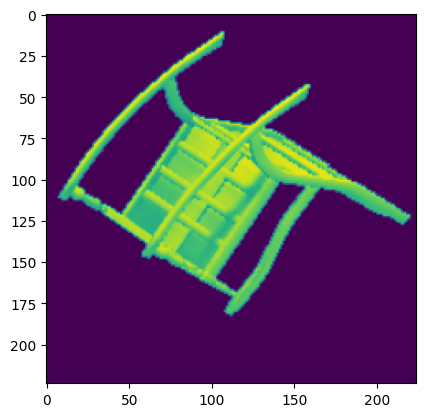

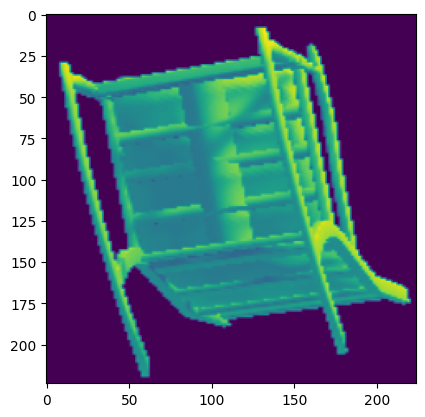

In [7]:
plt.imshow((im_test*255).astype('uint8'))
plt.show()
plt.imshow((im_list[indexeeeeeees][max_index]*255).astype('uint8'))

26/10/2022

ssim_i [0.21759175 0.         0.         0.         0.         0.29419008
 0.         0.11597171 0.         0.16216463 0.         0.
 0.         0.         0.23567691 0.20402451 0.21063562 0.2523756
 0.20181893 0.37924322 0.1812814  0.3629769  0.         0.
 0.         0.         0.40271634 0.         0.29531026 0.
 0.20325369 0.20682529 0.         0.22246447 0.         0.
 0.15247114 0.         0.         0.21105886 0.30136165 0.1627944
 0.15277365 0.16163318 0.         0.37389052 0.         0.23744334
 0.         0.3398636  0.22601667 0.         0.20509382 0.27104726
 0.25559595 0.18545099 0.38747    0.24299762 0.24284495 0.3208012
 0.        ]
max ssim i 0.40271633863449097
max index i [26]
ssim_i [0.2575166  0.23823023 0.         0.         0.27072635 0.
 0.         0.         0.2242143  0.23717494 0.09867592 0.23749046
 0.1442342  0.27824053 0.30743587 0.         0.         0.
 0.19861679 0.         0.         0.         0.         0.29805803
 0.2597486  0.         0.         0.24

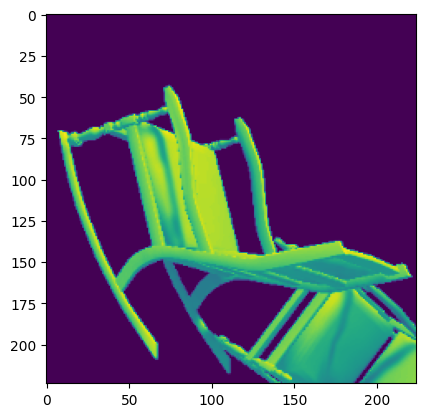

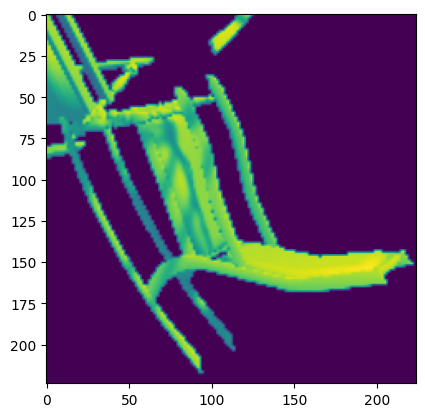

_________________________________________________________________________________________________________________________________________


In [7]:
# im_test = im_list[0]
# print(im_test.shape)
# d1, d2, d3 = im_test.shape
# # im_test_pca = im_test.reshape((1, d1*d2*d3))
# im_test_pca = im_test.reshape((d1*d2*d3))
# im_test_pca = scale(im_test_pca)

# im_test_pca = PCA(n_components=2).fit_transform(im_test_pca.reshape(-1, 1))

def load_images_pca(path):
    img_list = []
    for im in sorted(os.listdir(path)):
        image = (load_img(os.path.join(path, 
                                    im), color_mode='grayscale'))
        image = img_to_array(image)
        image = np.divide(image, 255)
        image = image.astype('float32')
        img_list.append(image)

    img_list = np.array(img_list)
    return img_list

def run_pca_and_kmedoids(path, PCA_dim, num_cluster, test_set_data_size):

    im_list = load_images_pca(path)
    d1, d2, d3, d4 = im_list.shape
    im_list_pca = im_list.reshape((d1, d2*d3*d4))
    im_list_pca = scale(im_list_pca)


    im_list_pca = PCA(n_components=PCA_dim).fit_transform(im_list_pca)
    test_indexes = [np.random.randint(0, d1) for _ in range(test_set_data_size)]

    im_test = im_list[test_indexes]
    im_test_pca = im_list_pca[test_indexes]

    im_list_pca = np.delete(im_list_pca, test_indexes, axis=0)
    im_list = np.delete(im_list, test_indexes, axis=0)
    kmedoids = KMedoids(n_clusters=num_cluster, random_state=42).fit(im_list_pca)

    # labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_

    return im_list, im_list_pca, im_test, im_test_pca, kmedoids


def kmedoids_predict(cluster_centers, test_sample_exp):
    dist_list = []
    for center in cluster_centers:
        dist_list.append(np.linalg.norm(test_sample_exp - center))
    dist_list = np.array(dist_list)
    ordered_dist = sorted(dist_list)

    ind = [i for i, x in enumerate(dist_list) if x in ordered_dist[:3]]

    return dist_list, ind
    

def retrive_best_indices(ind, kmedoids):
    labels = kmedoids.labels_
    index_list = []

    for i in ind:
        index_list.append(np.where(labels == i)[0])

    return np.concatenate(index_list).ravel()


def dataLoaderImagesAutoencoderBPR(img_list_loaded, batch_size):
    L = len(img_list_loaded)
    k = int(np.ceil(L / batch_size))
    # print(L)

    for i in range(0, k):
        # print(i)
        start = int(math.floor(i * L / k))
        stop = int(math.floor((i + 1) * L / k))
        # print(f"start is {start} while stop is {stop}")

        if stop > L:
            # print('bau')
            x_img = img_list_loaded[start:L]
        
        else:
            x_img = img_list_loaded[start:stop]

        yield x_img


def autoencoder_inference(autoencoderBPR4, dataLoader, im_test):
    max_ssim, max_index = -1, -1
    for i, batch in enumerate(dataLoader):
        _, ssim_i = autoencoderBPR4.predict([np.expand_dims(im_test, 0), batch])
        # print(index_i)
        # print(ssim_i)
        max_ssim_i = np.max(ssim_i)
        print(f"ssim_i {ssim_i}")
        print(f"max ssim i {np.max(ssim_i)}")
        max_index_i = np.where(ssim_i == max_ssim_i)[0]
        print(f"max index i {max_index_i}")
        if max_ssim_i > max_ssim:
            max_ssim = max_ssim_i
            max_index = max_index_i + batch.shape[0] * i
    return max_ssim, max_index




# im_list, im_list_pca, im_test, im_test_pca, kmedoids = run_pca_and_kmedoids("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 
#                                                         PCA_dim=2, num_cluster=64, test_set_data_size=5)

best_clusters_per_images = []

for i, im in enumerate(im_test_pca):
    t1 = time.time()
    dist_list, ind = kmedoids_predict(cluster_centers=kmedoids.cluster_centers_, test_sample_exp=im)
    # print(len(kmedoids.cluster_centers_))
    # print(len(kmedoids.labels_))
    # print(ind)
    best_clusters_per_images.append(np.array(ind))
    im_indexes = retrive_best_indices(ind, kmedoids)
    # print(im_indexes)
    max_ssim, max_index = autoencoder_inference(autoencoderBPR4, dataLoaderImagesAutoencoderBPR(im_list[im_indexes], 64), im_test[i])
    t2 = time.time()
    print(f"TOTAL TIME FOR ONE LOOP {t2 - t1}")
    print(f"test image at index {i}, max ssim {max_ssim}, and max index {max_index}")
    plt.imshow((im_test[i]*255).astype('uint8'))
    plt.show()
    plt.imshow((im_list[im_indexes][max_index][0]*255).astype('uint8'))
    plt.show()
    print('_________________________________________________________________________________________________________________________________________')
    break
    
    



TOTAL TIME FOR ONE LOOP 1.6210613250732422
test image at index 0, max ssim 0.5775275230407715, and max index [1200]


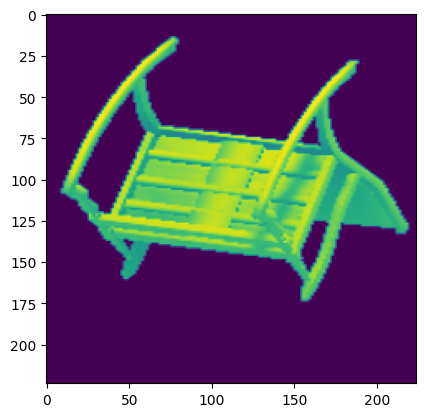

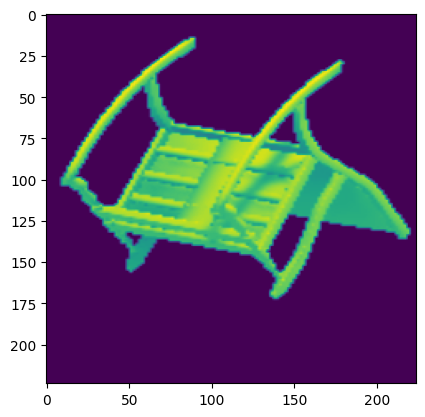

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 5.4200639724731445
test image at index 1, max ssim 0.6541439294815063, and max index [1648]


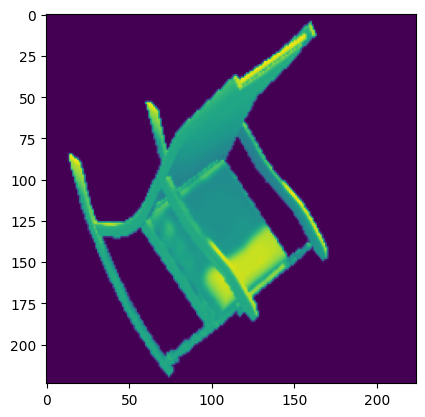

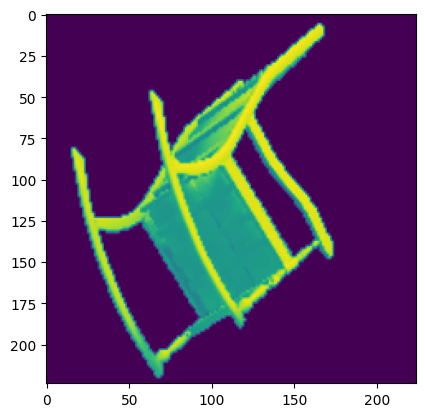

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 1.4347882270812988
test image at index 2, max ssim 0.5916630625724792, and max index [240]


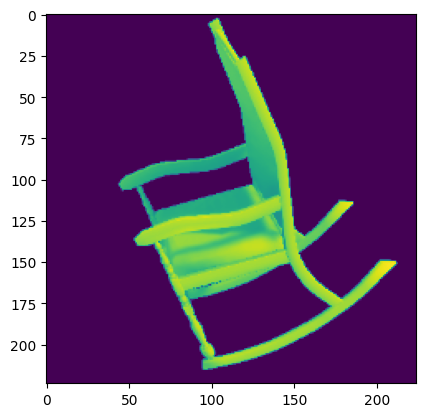

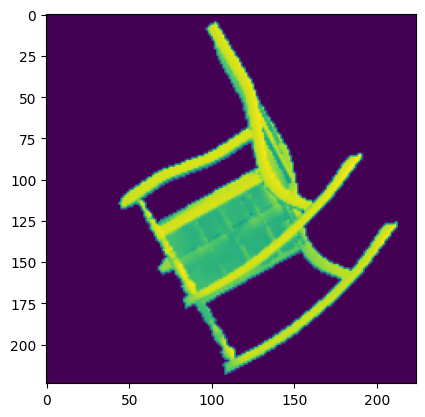

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 4.688141584396362
test image at index 3, max ssim 0.6700849533081055, and max index [780]


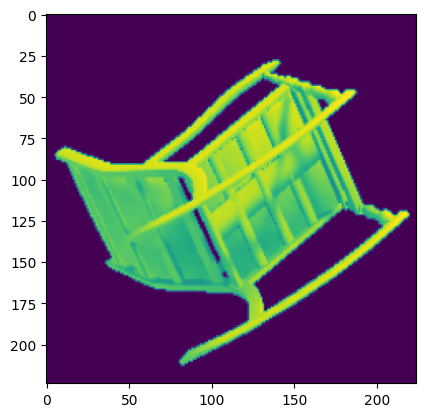

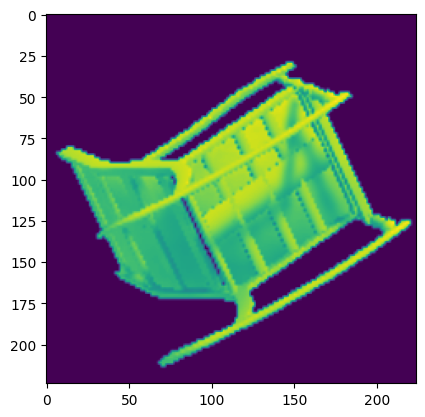

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 1.5656161308288574
test image at index 4, max ssim 0.37939244508743286, and max index [739]


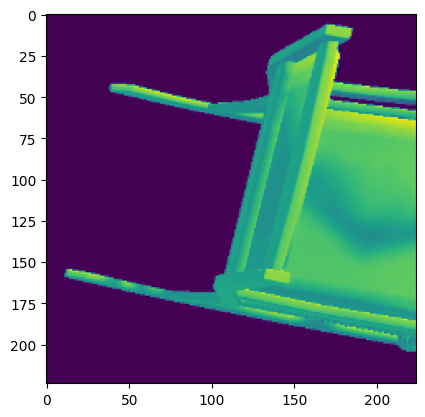

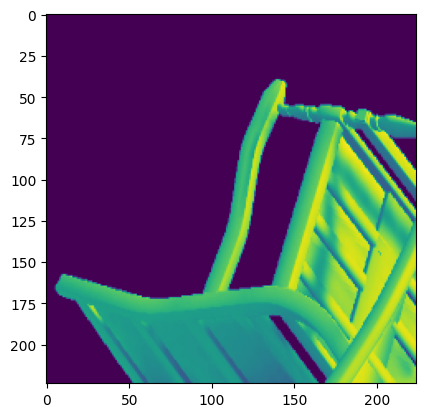

_________________________________________________________________________________________________________________________________________


In [3]:
"""
MY ATTEMPT
"""

def load_images_pca(path):
    img_list = []
    for im in sorted(os.listdir(path)):
        image = (load_img(os.path.join(path, 
                                    im), color_mode='grayscale'))
        image = img_to_array(image)
        image = np.divide(image, 255)
        image = image.astype('float32')
        img_list.append(image)

    img_list = np.array(img_list)
    return img_list

def run_pca_and_kmedoids(path, PCA_dim, num_cluster, test_set_data_size):

    im_list = load_images_pca(path)
    d1, d2, d3, d4 = im_list.shape
    im_list_pca = im_list.reshape((d1, d2*d3*d4))
    im_list_pca = scale(im_list_pca)


    im_list_pca = PCA(n_components=PCA_dim).fit_transform(im_list_pca)
    test_indexes = [np.random.randint(0, d1) for _ in range(test_set_data_size)]

    im_test = im_list[test_indexes]
    im_test_pca = im_list_pca[test_indexes]

    im_list_pca = np.delete(im_list_pca, test_indexes, axis=0)
    im_list = np.delete(im_list, test_indexes, axis=0)
    kmedoids = KMedoids(n_clusters=num_cluster, random_state=42).fit(im_list_pca)

    # labels, cluster_centers = kmedoids.labels_, kmedoids.cluster_centers_

    return im_list, im_list_pca, im_test, im_test_pca, kmedoids


def kmedoids_predict(cluster_centers, test_sample_exp):
    dist_list = []
    for center in cluster_centers:
        dist_list.append(np.linalg.norm(test_sample_exp - center))
    dist_list = np.array(dist_list)
    ordered_dist = sorted(dist_list)

    ind = [i for i, x in enumerate(dist_list) if x in ordered_dist[:3]]

    return dist_list, ind
    

def retrive_best_indices(ind, kmedoids):
    labels = kmedoids.labels_
    index_list = []

    for i in ind:
        index_list.append(np.where(labels == i)[0])

    return np.concatenate(index_list).ravel()


def dataLoaderImagesAutoencoderBPR(img_list_loaded, batch_size):
    L = len(img_list_loaded)
    k = int(np.ceil(L / batch_size))
    # print(L)

    for i in range(0, k):
        # print(i)
        start = int(math.floor(i * L / k))
        stop = int(math.floor((i + 1) * L / k))
        # print(f"start is {start} while stop is {stop}")

        if stop > L:
            # print('bau')
            x_img = img_list_loaded[start:L]
        
        else:
            x_img = img_list_loaded[start:stop]

        yield x_img


def autoencoder_inference(autoencoderBPR4, dataLoader, im_test):
    max_ssim, max_index = -1, -1
    batch_count = 0
    for i, batch in enumerate(dataLoader):
        _, ssim_i = autoencoderBPR4.predict([np.expand_dims(im_test, 0), batch])
        # print(index_i)
        # print(ssim_i)
        max_ssim_i = np.max(ssim_i)
        # print(f"ssim_i {ssim_i}")
        # print(f"max ssim i {np.max(ssim_i)}")
        max_index_i = np.where(ssim_i == max_ssim_i)[0]
        # print(f"max index i {max_index_i}")
        if max_ssim_i > max_ssim:
            max_ssim = max_ssim_i
            max_index = max_index_i + batch_count
        batch_count += batch.shape[0]
    return max_ssim, max_index




# im_list, im_list_pca, im_test, im_test_pca, kmedoids = run_pca_and_kmedoids("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 
#                                                         PCA_dim=2, num_cluster=64, test_set_data_size=5)

best_clusters_per_images = []

for i, im in enumerate(im_test_pca):
    t1 = time.time()
    dist_list, ind = kmedoids_predict(cluster_centers=kmedoids.cluster_centers_, test_sample_exp=im)
    # print(len(kmedoids.cluster_centers_))
    # print(len(kmedoids.labels_))
    # print(ind)
    best_clusters_per_images.append(np.array(ind))
    im_indexes = retrive_best_indices(ind, kmedoids)
    # print(im_indexes)
    max_ssim, max_index = autoencoder_inference(autoencoderBPR4, dataLoaderImagesAutoencoderBPR(im_list[im_indexes], 64), im_test[i])
    t2 = time.time()
    print(f"TOTAL TIME FOR ONE LOOP {t2 - t1}")
    print(f"test image at index {i}, max ssim {max_ssim}, and max index {max_index}")
    plt.imshow((im_test[i]*255).astype('uint8'))
    plt.show()
    plt.imshow((im_list[im_indexes][max_index][0]*255).astype('uint8'))
    plt.show()
    print('_________________________________________________________________________________________________________________________________________')

    



/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/envs/matteovenv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


TOTAL TIME FOR ONE LOOP 1.6146790981292725
test image at index 0, max ssim 0.5756139159202576, and max index [1152]


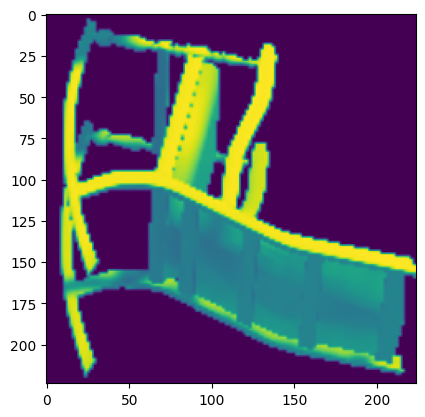

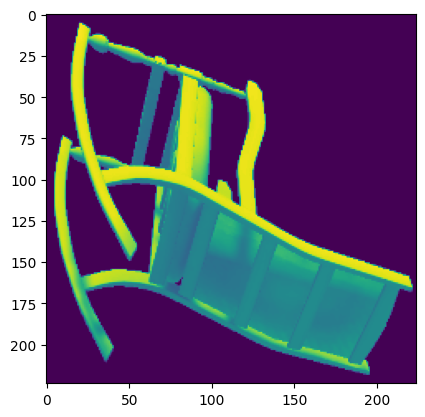

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 2.4142062664031982
test image at index 1, max ssim 0.6249377131462097, and max index [1370]


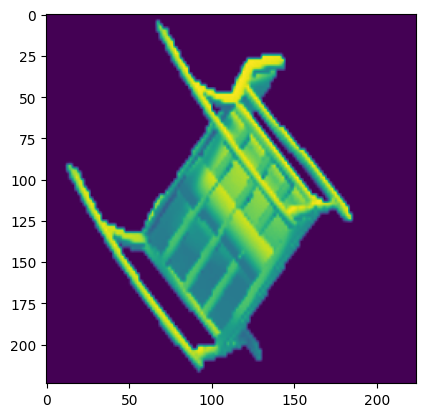

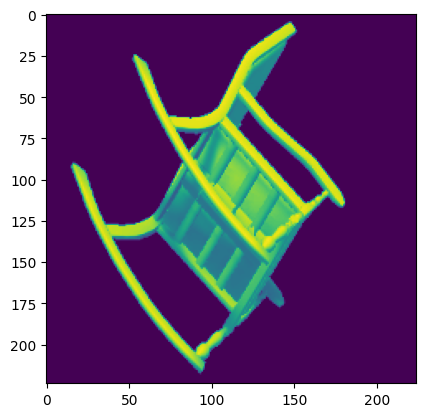

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 1.6368112564086914
test image at index 2, max ssim 0.6311542391777039, and max index [412]


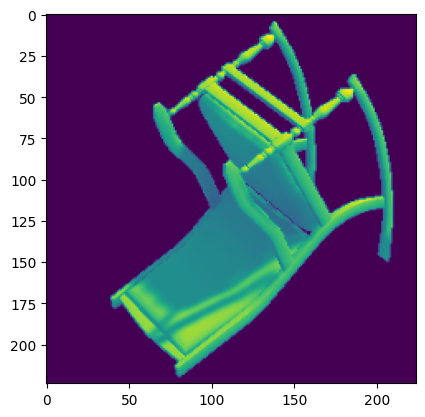

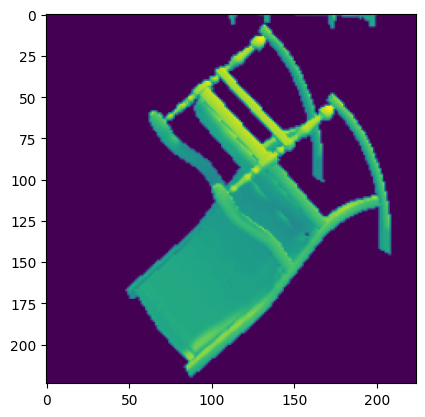

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 1.4942705631256104
test image at index 3, max ssim 0.5709145665168762, and max index [273]


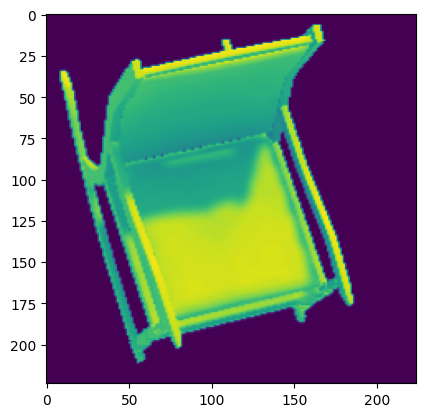

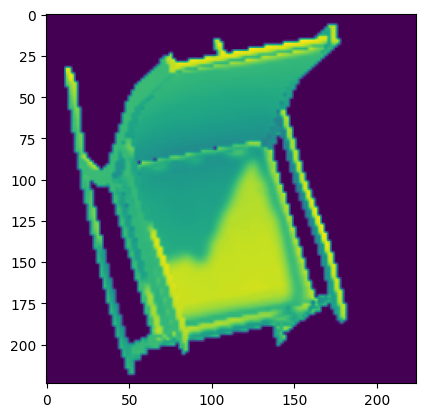

_________________________________________________________________________________________________________________________________________
TOTAL TIME FOR ONE LOOP 1.7697200775146484
test image at index 4, max ssim 0.5438874959945679, and max index [187]


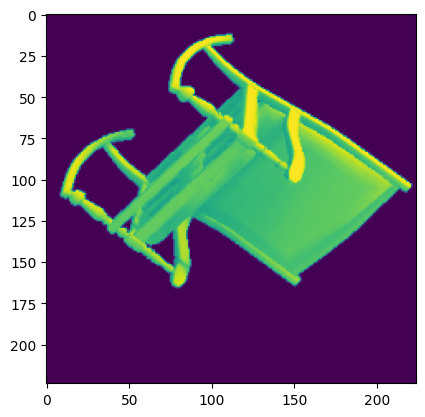

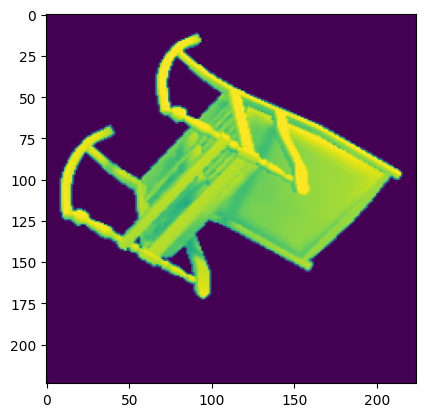

_________________________________________________________________________________________________________________________________________


In [4]:
im_list, im_list_pca, im_test, im_test_pca, kmedoids = run_pca_and_kmedoids("/dev/shm/new_dataset_9000_11_08_grayscale_transparent/content/new_dataset_9000_11_08_grayscale_transparent/new_transparent/", 
                                                        PCA_dim=2, num_cluster=64, test_set_data_size=5)


for i, im in enumerate(im_test_pca):
    t1 = time.time()
    dist_list, ind = kmedoids_predict(cluster_centers=kmedoids.cluster_centers_, test_sample_exp=im)
    im_indexes = retrive_best_indices(ind, kmedoids)
    max_ssim, max_index = autoencoder_inference(autoencoderBPR4, dataLoaderImagesAutoencoderBPR(im_list[im_indexes], 64), im_test[i])
    t2 = time.time()
    print(f"TOTAL TIME FOR ONE LOOP {t2 - t1}")
    print(f"test image at index {i}, max ssim {max_ssim}, and max index {max_index}")
    plt.imshow((im_test[i]*255).astype('uint8'))
    plt.show()
    plt.imshow((im_list[im_indexes][max_index][0]*255).astype('uint8'))
    plt.show()
    print('_________________________________________________________________________________________________________________________________________')